In [1]:
import os
os.environ['TF_CP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

GPU setting. It isn't neccessary in CoLab.

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[]


**Load synthetic 5-mer traning data**

In [ ]:
with open('/content/drive/MyDrive/009.1.mid.position.base.array.pkl', 'rb') as file:
    y_arr =pickle.load(file)
with open('/content/drive/MyDrive/009.2.5mer.feature.pkl', 'rb') as file:
    x_arr_3d = pickle.load(file)
print(y_arr.shape)
print(x_arr_3d.shape)

(214966, 5)
(214966, 5, 7)


**Load mouse cell line 5-mer data, no BrdU labeling to supplement the synthetic 5-mer training data**

In [ ]:

mouse_x = np.load("/content/drive/MyDrive/mouse.combined_array.npy")

In [ ]:
print(mouse_x.shape)

(8279453, 5, 7)


**Generate lables for the mouse 5-mer data: the middle bases are all Ts**

In [ ]:
#generate labels for mouse 5mers, which are Ts always
mouse_y = np.full((mouse_x.shape[0], 1), "T")

# convert dummies using the universe ["A", "B" "C", "G", "T"]
# using some trick
aplhabets = np.array(["A", "B", "C", "G", "T"]).reshape(5, 1)

mouse_y_p = np.vstack((aplhabets,mouse_y), dtype=object)
mouse_label = pd.get_dummies(mouse_y_p.ravel(), dtype=float).values

# remove the first 5 rows which was added so that one-hot encoding work properly
mouse_label = mouse_label[5:, :]

**Prepare mouse 5-mer data for training**

In [ ]:
# shuffle mouse_x and mouse_label
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

n_shuffles = 5
for i in range(n_shuffles):
    mouse_x, mouse_label = shuffle(mouse_x, mouse_label, random_state= i )
# split mouse_x and mouse_label for training
X_train_mouse, X_test_mouse, y_train_mouse, y_test_mouse = \
         train_test_split(mouse_x, mouse_label, test_size=0.99, random_state=42)


In [ ]:
print(X_train_mouse.shape)
print(y_train_mouse.shape)
print(X_test_mouse.shape)
print(y_test_mouse.shape)

(82794, 5, 7)
(82794, 5)
(8196659, 5, 7)
(8196659, 5)


**Prepare synthetic 5-mer data for training**

In [ ]:

n_shuffles = 5

for i in range(n_shuffles):
    x_arr_3d, y_arr = shuffle(x_arr_3d, y_arr, random_state= i )


X_train, X_test, y_train, y_test = train_test_split(x_arr_3d, y_arr, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(171972, 5, 7)
(171972, 5)
(42994, 5, 7)
(42994, 5)


**Combine the mouse and synthetic 5-mer data for training**

In [ ]:
##combine X_train_mouse with X_train and combine y_train_mouse with y_train
X_train = np.concatenate((X_train, X_train_mouse), axis=0)
y_train = np.concatenate((y_train, y_train_mouse), axis=0)

## shuffle  X_train and y_train
X_train, y_train = shuffle(X_train, y_train, random_state= 100)
print(X_train.shape)
print(y_train.shape)

(254766, 5, 7)
(254766, 5)


**Handle imbalanced data with class weight**

In [ ]:
from sklearn.utils import class_weight

y_train_labels= np.where(y_train==1)[1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(1.1497698348226375), 1: np.float64(2.229899343544858), 2: np.float64(1.1696976653428526), 3: np.float64(1.5447385175079582), 4: np.float64(0.4588146307201902)}


**Specify model layout**

In [ ]:
model = keras.Sequential([
    # tf.keras.Input()-- instantiate a Keras tensor
    # In TensorFlow Keras, input layers are essential for defining the expected
    # shape and data type of input data for a neural network. There are two primary
    #  ways to define input layers: keras.Input and keras.layers.InputLayer.
    # --keras.Input: This approach is often favored for its conciseness and flexibility,
    #  especially when building models using the Functional API. It directly creates a
    # symbolic tensor-like object representing the input.
    # Define an input layer for a sequence of 5 time steps with 7 features each
    # None for batch size
    keras.Input(shape = (5,7), dtype = "float32"),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units=128)),
    layers.Dense(units = 5, activation='softmax')
])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 5, 256)              │         105,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 5, 256)              │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,397 (2.67 MB)

 Trainable params: 699,397 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None


**Compile and fit the model**

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              # If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss
              # from_logits in keras.losses.CategoricalCrossentropy should be set to True when the
              # output of your model's last layer has not passed through a softmax
              # activation function.
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction='sum_over_batch_size',
                    name='categorical_crossentropy'
                  ),
              loss_weights = None,
              metrics=['categorical_accuracy', 'precision', 'recall',
                       keras.metrics.AUC(name='prc', curve='PR')])

In [ ]:
model.fit(X_train, y_train,
          batch_size = 128,
          # An epoch, in Machine Learning, is the entire processing
          # by the learning algorithm of the entire train-set.
          epochs = 10,
          class_weight = class_weights_dict,
          verbose = 2)

Epoch 1/10
1991/1991 - 295s - 148ms/step - categorical_accuracy: 0.8530 - loss: 0.2782 - prc: 0.9450 - precision: 0.8735 - recall: 0.8374
Epoch 2/10
1991/1991 - 262s - 132ms/step - categorical_accuracy: 0.9162 - loss: 0.1647 - prc: 0.9762 - precision: 0.9171 - recall: 0.9153
Epoch 3/10
1991/1991 - 263s - 132ms/step - categorical_accuracy: 0.9275 - loss: 0.1455 - prc: 0.9812 - precision: 0.9284 - recall: 0.9266
Epoch 4/10
1991/1991 - 321s - 161ms/step - categorical_accuracy: 0.9338 - loss: 0.1332 - prc: 0.9841 - precision: 0.9346 - recall: 0.9331
Epoch 5/10
1991/1991 - 323s - 162ms/step - categorical_accuracy: 0.9394 - loss: 0.1229 - prc: 0.9861 - precision: 0.9401 - recall: 0.9385
Epoch 6/10
1991/1991 - 323s - 162ms/step - categorical_accuracy: 0.9429 - loss: 0.1125 - prc: 0.9879 - precision: 0.9438 - recall: 0.9422
Epoch 7/10
1991/1991 - 321s - 161ms/step - categorical_accuracy: 0.9481 - loss: 0.1017 - prc: 0.9896 - precision: 0.9488 - recall: 0.9475
Epoch 8/10
1991/1991 - 321s - 161m

**Evaluate the model with testing data**

In [ ]:
model.evaluate(X_test, y_test,
               batch_size = 128,
               verbose = 2)

336/336 - 15s - 44ms/step - categorical_accuracy: 0.9398 - loss: 0.1888 - prc: 0.9807 - precision: 0.9403 - recall: 0.9396


[0.1887774020433426,
 0.9398055672645569,
 0.940274178981781,
 0.9395962357521057,
 0.9806562662124634]

In [ ]:
print("model.input_shape:", model.input_shape)

In [ ]:
## confusion matrix
labels= np.where(y_test==1)[1]
predictions = model.predict(X_test)


[2 2 4 ... 1 0 1]
1344/1344 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step


In [ ]:
def softmax_to_label(softmax_output):
  """Converts softmax probabilities to a label encoded value.

  Args:
    softmax_output: A list or numpy array of probabilities.

  Returns:
    The index of the highest probability.
  """
  return np.argmax(softmax_output)

**Show the confusion matrix**

In [ ]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

42994
[[11320    19    20    13    13]
 [   13  4758    12    13   873]
 [   15    22 10811    14    20]
 [   18    12    18  8004    10]
 [   20  1432    17    14  5513]]


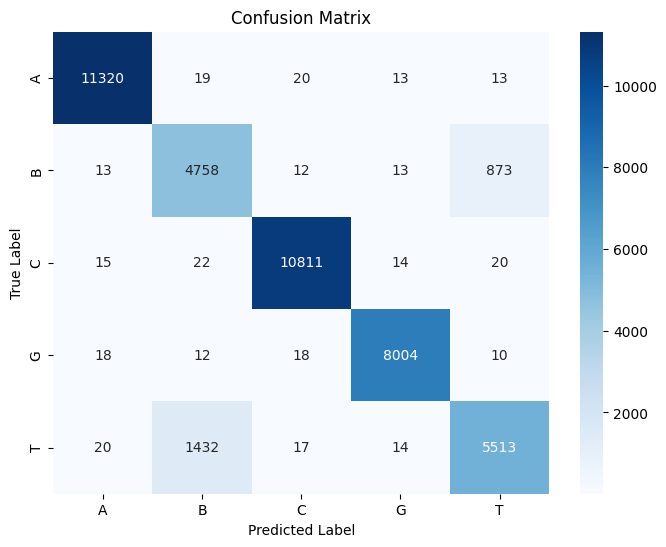

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion_matrix.numpy(), class_names)
# Evaluate the confusion matrix within a TensorFlow session or eager context
# with tf.compat.v1.Session() as sess:
#     np_cm = sess.run(confusion_matrix)
#     plot_confusion_matrix(np_cm, class_names)

**Test the model using more mouse testing data**

In [ ]:
# for mouse data, negative data
model.evaluate(X_test_mouse[1:100000], y_test_mouse[1:100000],
               batch_size = 128,
               verbose = 2)

782/782 - 29s - 38ms/step - categorical_accuracy: 0.9655 - loss: 0.0880 - prc: 0.9946 - precision: 0.9659 - recall: 0.9652


[0.08798833191394806,
 0.9655096530914307,
 0.9658851027488708,
 0.9651896357536316,
 0.9946462512016296]

In [ ]:
## confusion matrix
labels= np.where(y_test_mouse[1:100000]==1)[1]
print(labels)
predictions = model.predict(X_test_mouse[1:100000])

[4 4 4 ... 4 4 4]
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step


In [ ]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

99999
[[    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    8  3426     1    14 96550]]


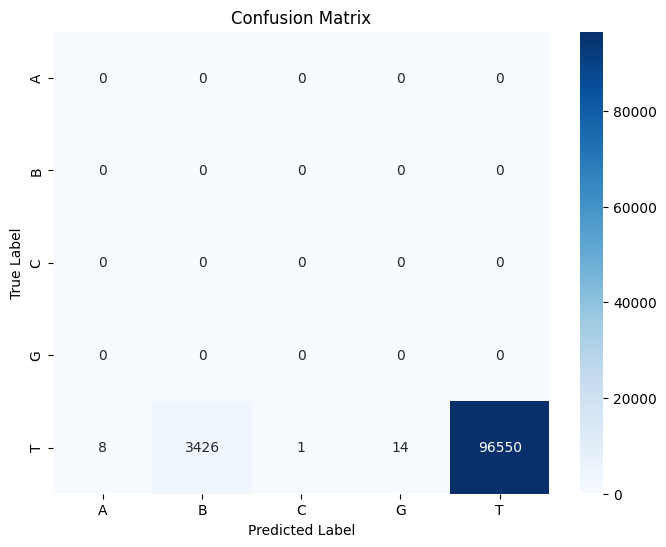

In [ ]:
class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion_matrix.numpy(), class_names)
# Evaluate the confusion matrix within a TensorFlow session or eager context
# with tf.compat.v1.Session() as sess:
#     np_cm = sess.run(confusion_matrix)
#     plot_confusion_matrix(np_cm, class_names)

**Save the model because it looks pretty good**

In [ ]:
model.save('/content/drive/MyDrive/BrdU.basecaller.model.trained.w.mouse.data.keras')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BrdU.basecaller.model.trained.w.mouse.data.keras')

**Test the model performance at the read level with the mouse (BrdU-free) and human (~20% of reads are BrdU+) nanopore sequencing data**

In [ ]:
## mouse data
out_dir = '/content/drive/MyDrive'
filename = 'barcode1.file.names'
pickle_files = os.listdir('/content/drive/MyDrive/barcode01')
with open(os.path.join(out_dir, ''.join([filename, '.pkl'])), 'wb') as file:
       pickle.dump(pickle_files, file)

percentages = np.zeros(len(pickle_files))
for i, p in enumerate(pickle_files):
  with open(f'/content/drive/MyDrive//barcode01/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=2)
    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    percentages[i] = BrdU_percentage

In [ ]:
filename = 'barcode01.BrdU_percentage'
with open(os.path.join(out_dir, ''.join([filename, '.pkl'])), 'wb') as file:
  pickle.dump(percentages, file)

In [ ]:
brdu = np.where(percentages > 0.5)
read_id = np.array(pickle_files)[brdu]
print(read_id)

In [ ]:
##human data
out_dir = '/content/drive/MyDrive'
filename = 'barcode1.file.names'
pickle_files = os.listdir('/content/drive/MyDrive/barcode02')
with open(os.path.join(out_dir, ''.join([filename, '.pkl'])), 'wb') as file:
       pickle.dump(pickle_files, file)

percentages = np.zeros(len(pickle_files))
for i, p in enumerate(pickle_files):
  with open(f'/content/drive/MyDrive//barcode02/{p}', 'rb') as file:
    X_test = pickle.load(file)
    predictions = model.predict(X_test, verbose=2)
    predictions_labels = np.apply_along_axis(softmax_to_label,  1, predictions)
    BrdU_percentage = np.sum(predictions_labels==1)/len(predictions_labels)
    percentages[i] = BrdU_percentage

**Compare the % of Ts called as BrdU per reads in the mouse and human data**

In [ ]:
filename = 'barcode02.BrdU_percentage'
out_dir = '/content/drive/MyDrive'
filename = 'barcode02.BrdU_percentage'
with open(os.path.join(out_dir, ''.join([filename, '.pkl'])), 'wb') as file:
  pickle.dump(percentages, file)

brdu = np.where(percentages >= 0.09)
read_id = np.array(pickle_files)[brdu]

with open('/content/drive/MyDrive/Humand.read.IDs.with.ge.9%.T.called.as.BrdU.txt', 'w') as file:
  print('\n'.join(list(read_id)), file=file)


In [2]:
## check %T called as BrdU in mouse data
with open("/content/drive/MyDrive/barcode01.BrdU_percentage.pkl", "rb") as file:
    mouse_BrdU_percentage = pickle.load(file)
mouse_BrdU_percentage = np.array(mouse_BrdU_percentage) *100
print(mouse_BrdU_percentage)

[3.7566678  4.58452722 4.05257393 ... 2.63024785 3.73937677 3.85375494]


In [3]:
with open("/content/drive/MyDrive/barcode02.BrdU_percentage.pkl", "rb") as file:
    human_BrdU_percentage = pickle.load(file)
human_BrdU_percentage = np.array(human_BrdU_percentage) *100
print(human_BrdU_percentage)

[ 4.49859419 16.06606607  4.69644903 ...  1.73160173 13.41544607
  2.52935863]


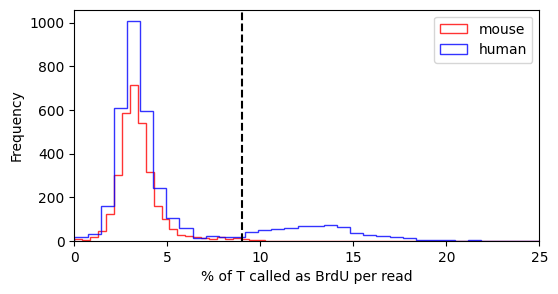

In [4]:
#generate a histogram for BrdU_percentage
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(6, 3))
# plotting first histogram

plt.hist(mouse_BrdU_percentage, label='mouse', bins =100, alpha=.8, color='red', histtype= 'step')
# plotting second histogram
plt.hist(human_BrdU_percentage, label='human', bins =100,  alpha=.8, color='blue',  histtype= 'step')
# plot a dashed vertical line at x=9
plt.axvline(x=9, color='black', linestyle='--')

plt.xlabel("% of T called as BrdU per read")
plt.ylabel("Frequency")
plt.xlim(0,25)
plt.legend()
plt.show();

In [5]:
human_brdu_reads = (human_BrdU_percentage>=9).sum()
mouse_brdu_reads = (mouse_BrdU_percentage>=9).sum()
print(f'#Human reads with ge 10% of Ts called as BrdU: {human_brdu_reads}\t{human_brdu_reads/len(human_BrdU_percentage)*100:.2f}%')
print(f'#Mouse reads with ge 10% of Ts called as BrdU: {mouse_brdu_reads} \t{mouse_brdu_reads/len(mouse_BrdU_percentage)*100:.2f}%')

#Human reads with ge 10% of Ts called as BrdU: 604	17.33%
#Mouse reads with ge 10% of Ts called as BrdU: 17 	0.55%
